<h1 style="text-align: center">
Deep Learning HW4 </br>
Binary Classification using Sequential models
</h1>



  <style>
    table {
      width: 100%;
      border-collapse: collapse;
    }

    th, td {
      border: 1px solid #dddddd;
      text-align: left;
      padding: 8px;
    }

    th {
      background-color: #f2f2f2;
    }

    .box {
      border: 1px solid #000;
      padding: 10px;
      width: 400px; /* Adjust the width as needed */
      margin: 20px auto;
    }
  </style>
</head>
<body>

<div class="box">
  <table>
    <tr>
      <th colspan="2">Personal Info</th>
    </tr>
    <tr>
      <td>First Name:</td>
      <td>Ali</td>
    </tr>
    <tr>
      <td>Last Name:</td>
      <td>Nikkhah</td>
    </tr>
    <tr>
      <td>Student Number:</td>
      <td>99102445</td>
    </tr>
    <tr>
      <td>Git:</td>
      <td><a href="https://github.com/AliNikkhah2001/DataScience02" target="_blank">https://github.com/AliNikkhah2001/DeepLearning02</a></td>
    </tr>
  </table>
</div>



# Sequential Model Binary Classification problem

# Imports and Initial steps

In [5]:
!pip install rdkit
!pip install seaborn


[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 4.9 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [6]:
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
from rdkit import Chem
from collections import Counter
import pandas as pd
from rdkit import Chem
import warnings
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import ChemicalFeatures
from collections import Counter
import heapq
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Flatten, Dense
import tensorflow as tf
from tqdm.keras import TqdmCallback
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Flatten, Dense
from sklearn.preprocessing import LabelEncoder
import os
import tqdm as tqdm
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Bidirectional
from sklearn.model_selection import StratifiedKFold
from keras.callbacks import ModelCheckpoint


/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Dataset import

In [7]:
# Load the BBBP dataset from the provided CSV file
data_path = '/kaggle/input/bbbpdataset/BBBP.csv'
bbbp_data = pd.read_csv(data_path)
# Display the head of the dataset
print(bbbp_data.head())

   num                  name  p_np  \
0    1            Propanolol     1   
1    2  Terbutylchlorambucil     1   
2    3                 40730     1   
3    4                    24     1   
4    5           cloxacillin     1   

                                              smiles  
0                   [Cl].CC(C)NCC(O)COc1cccc2ccccc12  
1           C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl  
2  c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO...  
3                   C1CCN(CC1)Cc1cccc(c1)OCCCNC(=O)C  
4  Cc1onc(c2ccccc2Cl)c1C(=O)N[C@H]3[C@H]4SC(C)(C)...  


**Refrences for deciding on tokenizing approach**
- https://s3-eu-west-1.amazonaws.com/itempdf74155353254prod/12339368/SMILES_Pair_Encoding__A_Data-Driven_Substructure_Tokenization_Algorithm_for_Deep_Learning_v1.pdf
- https://jcheminf.biomedcentral.com/articles/10.1186/s13321-023-00725-9
- https://github.com/deepchem/deepchem/blob/master/examples/tutorials/Transfer_Learning_With_ChemBERTa_Transformers.ipynb

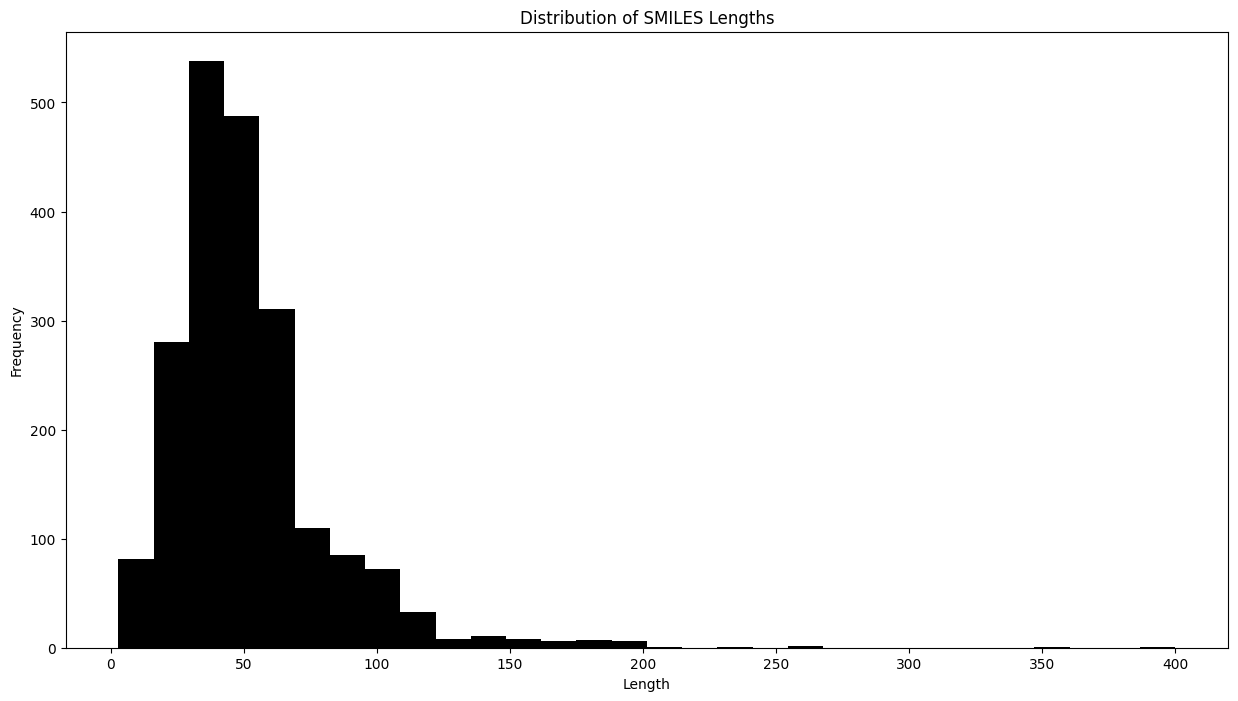

Min Length: 3
Max Length: 400


In [8]:
# Tokenize SMILES strings and calculate lengths
smiles_lengths = bbbp_data['smiles'].apply(lambda x: len(list(x)))

# Plot the distribution of frequency-length
plt.figure(figsize=(15, 8))
plt.hist(smiles_lengths, bins=30, color='black')
plt.title('Distribution of SMILES Lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show()

# Print min and max length
min_length = smiles_lengths.min()
max_length = smiles_lengths.max()

print(f"Min Length: {min_length}")
print(f"Max Length: {max_length}")

The Simplified Molecular Input Line Entry System (SMILES) is a textual representation of chemical structures used to represent molecules and chemical reactions. It's a way to encode molecular structures as text strings using a specific syntax.

The SMILES format represents molecules using a line notation where atoms, bonds, and branches are depicted based on their connectivity and structural information.

Here's an explanation of the SMILES format 
The SMILES representation of a molecule is based on atoms and bonds. Atoms are represented by their elemental symbols.
Atoms are connected by bonds, which are represented by various symbols:

- **Single bond**: `-`
- **Double bond**: `=`
- **Triple bond**: `#`
- **Aromatic bond**: `:`

Branches and rings in molecules are depicted using parentheses `()` and square brackets `[]` respectively:

- **Branches**: `(` and `)` indicate branches attached to the main structure.
- **Rings**: `[` and `]` denote cyclic structures.


This representation means two Carbon atoms bonded together with a single bond, and one Oxygen atom bonded to one of the Carbon atoms.

The SMILES format offers a compact and human-readable way to represent molecular structures, making it useful in various areas of computational chemistry, including cheminformatics, database searching, and molecular modeling.

 SMILES strings represent chemical structures, and tokenizing them involves breaking down the strings into meaningful units or tokens. Here are some common approaches to tokenize SMILES:

1. **Element Symbols as Tokens:**
   - Approach: Treat each element symbol (e.g., H, C, O) as a separate token.
   - Example: `CCO` would be tokenized into `[C, C, O]`.

2. **Functional Groups as Tokens:**
   - Approach: Identify common functional groups (e.g., -OH, -COOH) as tokens.
   - Example: `CC(O)C` would be tokenized into `[C, C, (O), C]`.

3. **Special Characters as Tokens:**
   - Approach: Treat special characters with specific meanings (e.g., '=', '#', '@') as separate tokens.
   - Example: `CC=O` would be tokenized into `[C, C, =, O]`.

4. **Ring Closure Numbers as Tokens:**
   - Approach: Treat ring closure numbers as individual tokens.
   - Example: `C1CCCCC1` would be tokenized into `[C, 1, C, C, C, C, C, 1]`.

5. **Brackets and Parentheses as Tokens:**
   - Approach: Consider brackets and parentheses as separate tokens.
   - Example: `C(C(=O)O)O` would be tokenized into `[C, (, C, (, =, O, ), O, )]`.

6. **Breaking Bonds:**
   - Approach: Consider breaking bonds as tokens to capture structural information.
   - Example: `CCO` might be tokenized into `[C-C, C-O]` to represent different bonds.


## preprocess dataset and remove wrong formatted data

In [9]:
import warnings
from rdkit import Chem
from rdkit import RDLogger        
initial_length = len(bbbp_data)
print(f"Initial Length: {initial_length}")
# Filter out invalid SMILES
valid_smiles = bbbp_data['smiles'].apply(lambda x: Chem.MolFromSmiles(x) is not None)
# Calculate the number of invalid SMILES
invalid_smiles_count = len(bbbp_data) - valid_smiles.sum()
print(f"Number of invalid SMILES: {invalid_smiles_count}")
# Remove rows with invalid SMILES
bbbp_data = bbbp_data[valid_smiles]
# Print final length
final_length = len(bbbp_data)
print(f"Final Length: {final_length}")
# Print invalid SMILES samples
# Print valid SMILES samples
print("Valid SMILES Samples:")
print(bbbp_data[['smiles']])


Initial Length: 2050


[12:29:29] Explicit valence for atom # 1 N, 4, is greater than permitted
[12:29:29] WARNING: not removing hydrogen atom without neighbors
[12:29:29] Explicit valence for atom # 6 N, 4, is greater than permitted
[12:29:29] WARNING: not removing hydrogen atom without neighbors
[12:29:29] WARNING: not removing hydrogen atom without neighbors
[12:29:29] WARNING: not removing hydrogen atom without neighbors
[12:29:29] WARNING: not removing hydrogen atom without neighbors
[12:29:29] WARNING: not removing hydrogen atom without neighbors
[12:29:29] WARNING: not removing hydrogen atom without neighbors
[12:29:29] Explicit valence for atom # 6 N, 4, is greater than permitted
[12:29:29] WARNING: not removing hydrogen atom without neighbors
[12:29:29] WARNING: not removing hydrogen atom without neighbors
[12:29:29] WARNING: not removing hydrogen atom without neighbors
[12:29:29] WARNING: not removing hydrogen atom without neighbors
[12:29:29] Explicit valence for atom # 11 N, 4, is greater than pe

Number of invalid SMILES: 11
Final Length: 2039
Valid SMILES Samples:
                                                 smiles
0                      [Cl].CC(C)NCC(O)COc1cccc2ccccc12
1              C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl
2     c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO...
3                      C1CCN(CC1)Cc1cccc(c1)OCCCNC(=O)C
4     Cc1onc(c2ccccc2Cl)c1C(=O)N[C@H]3[C@H]4SC(C)(C)...
...                                                 ...
2045    C1=C(Cl)C(=C(C2=C1NC(=O)C(N2)=O)[N+](=O)[O-])Cl
2046  [C@H]3([N]2C1=C(C(=NC=N1)N)N=C2)[C@@H]([C@@H](...
2047  [O+]1=N[N](C=C1[N-]C(NC2=CC=CC=C2)=O)C(CC3=CC=...
2048  C1=C(OC)C(=CC2=C1C(=[N+](C(=C2CC)C)[NH-])C3=CC...
2049  [N+](=NCC(=O)N[C@@H]([C@H](O)C1=CC=C([N+]([O-]...

[2039 rows x 1 columns]


[12:29:29] WARNING: not removing hydrogen atom without neighbors
[12:29:29] WARNING: not removing hydrogen atom without neighbors
[12:29:29] WARNING: not removing hydrogen atom without neighbors
[12:29:29] WARNING: not removing hydrogen atom without neighbors
[12:29:29] WARNING: not removing hydrogen atom without neighbors
[12:29:29] WARNING: not removing hydrogen atom without neighbors
[12:29:29] WARNING: not removing hydrogen atom without neighbors
[12:29:29] WARNING: not removing hydrogen atom without neighbors
[12:29:29] WARNING: not removing hydrogen atom without neighbors


In [10]:
# Filter out invalid SMILES
valid_smiles_df = pd.DataFrame(bbbp_data, copy=True)

# Tokenizer decalration

## all characters as tokens

In [11]:
# Function to tokenize SMILES by character and output all vocabularies
def tokenize_smiles_all_characters(dataset):
    all_tokens = set()

    # Tokenize the dataset by character
    for smiles in dataset:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            tokens = [char for char in smiles]
            all_tokens.update(tokens)

    return all_tokens


# Tokenize the dataset by character and get all vocabularies
all_vocabularies = tokenize_smiles_all_characters(valid_smiles_df['smiles'])

# Print all vocabularies
print("All Vocabularies:")
print(all_vocabularies)

[12:29:31] WARNING: not removing hydrogen atom without neighbors
[12:29:31] WARNING: not removing hydrogen atom without neighbors
[12:29:31] WARNING: not removing hydrogen atom without neighbors
[12:29:31] WARNING: not removing hydrogen atom without neighbors
[12:29:31] WARNING: not removing hydrogen atom without neighbors
[12:29:31] WARNING: not removing hydrogen atom without neighbors
[12:29:31] WARNING: not removing hydrogen atom without neighbors
[12:29:31] WARNING: not removing hydrogen atom without neighbors
[12:29:31] WARNING: not removing hydrogen atom without neighbors
[12:29:31] WARNING: not removing hydrogen atom without neighbors
[12:29:31] WARNING: not removing hydrogen atom without neighbors
[12:29:31] WARNING: not removing hydrogen atom without neighbors
[12:29:31] WARNING: not removing hydrogen atom without neighbors
[12:29:31] WARNING: not removing hydrogen atom without neighbors
[12:29:31] WARNING: not removing hydrogen atom without neighbors
[12:29:31] WARNING: not r

All Vocabularies:
{'s', 'l', '@', 'O', '7', 'B', ']', 'N', 'I', '3', '4', 'c', '2', 'P', '8', '.', '(', '9', ')', 'o', '5', '#', 'H', 'r', '+', '%', '1', 'a', '6', '/', '\\', '-', 'F', 'C', '=', '[', 'S', '0', 'n'}


[12:29:31] WARNING: not removing hydrogen atom without neighbors
[12:29:31] WARNING: not removing hydrogen atom without neighbors
[12:29:31] WARNING: not removing hydrogen atom without neighbors
[12:29:31] WARNING: not removing hydrogen atom without neighbors
[12:29:31] WARNING: not removing hydrogen atom without neighbors
[12:29:31] WARNING: not removing hydrogen atom without neighbors
[12:29:31] WARNING: not removing hydrogen atom without neighbors
[12:29:31] WARNING: not removing hydrogen atom without neighbors
[12:29:31] WARNING: not removing hydrogen atom without neighbors
[12:29:31] WARNING: not removing hydrogen atom without neighbors


## obtained vocabulary: 
> {'4', 'F', 'C', '2', '=', '0', 'N', '#', 'I', 'r', 'a', '6', 'c', '.', 'S', '[', 'l', ')', '5', '/', 'o', '8', ']', 'O', '3', 'B', '+', 'P', 'n', 'H', '%', '1', '9', '(', '-', 's', '\\', '@', '7'}

## sample Vocabulary and Tokenized sample output

In [12]:
def tokenize_smiles_pair_encoding(dataset, max_vocab_size, frequency_threshold):
    all_tokens = []
    valid_dataset = []
    # Filter out invalid SMILES and tokenize
    for smiles in dataset:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            tokens = [atom.GetSymbol() for atom in mol.GetAtoms()]
            all_tokens.extend(tokens)
            valid_dataset.append(smiles)
    # Initialize the vocabulary with all unique tokens
    unique_tokens = list(set(all_tokens))
    vocabulary = set(unique_tokens)
    # Iteratively count the occurrence of token pairs and merge the most frequent pair
    while len(vocabulary) < max_vocab_size:
        token_counts = Counter(all_tokens)
        # Find the most frequent token pair
        most_common_pair = heapq.nlargest(1, token_counts.items(), key=lambda x: x[1])
        # Check if the frequency of the most common pair is above the threshold
        if most_common_pair and most_common_pair[0][1] > frequency_threshold and len(most_common_pair[0][0]) > 1:
            new_token = most_common_pair[0][0][0] + most_common_pair[0][0][1]
            vocabulary.add(new_token)
            all_tokens = [new_token if t == most_common_pair[0][0] else t for t in all_tokens]
        else:
            break
    # Tokenize the valid dataset using the created vocabulary
    tokenized_dataset = []
    for smiles in valid_dataset:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            tokens = [atom.GetSymbol() for atom in mol.GetAtoms()]
            tokenized_smiles = [token if token in vocabulary else 'UNK' for token in tokens]
            tokenized_dataset.append(tokenized_smiles)
    return tokenized_dataset, vocabulary

In [13]:
sample = ["CCO", "CC(=O)O", "C1CCN(CC1)Cc1cccc(c1)OCCCNC(=O)C"]
max_vocab_size = 400
frequency_threshold = 1
tokenized_dataset, vocabulary = tokenize_smiles_pair_encoding(sample, max_vocab_size, frequency_threshold)
# Print tokenized dataset and vocabulary
print("Tokenized sample:")
print(tokenized_dataset)
print("\nVocabulary:")
print(vocabulary)


Tokenized sample:
[['C', 'C', 'O'], ['C', 'C', 'O', 'O'], ['C', 'C', 'C', 'N', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'O', 'C', 'C', 'C', 'N', 'C', 'O', 'C']]

Vocabulary:
{'O', 'C', 'N'}


In [14]:
max_vocab_size = 400
frequency_threshold = 1


tokenized_dataset, vocabulary = tokenize_smiles_pair_encoding(valid_smiles_df['smiles'], max_vocab_size, frequency_threshold)
print(vocabulary)


[12:29:33] WARNING: not removing hydrogen atom without neighbors
[12:29:33] WARNING: not removing hydrogen atom without neighbors
[12:29:33] WARNING: not removing hydrogen atom without neighbors
[12:29:33] WARNING: not removing hydrogen atom without neighbors
[12:29:33] WARNING: not removing hydrogen atom without neighbors
[12:29:33] WARNING: not removing hydrogen atom without neighbors
[12:29:33] WARNING: not removing hydrogen atom without neighbors
[12:29:33] WARNING: not removing hydrogen atom without neighbors
[12:29:33] WARNING: not removing hydrogen atom without neighbors
[12:29:33] WARNING: not removing hydrogen atom without neighbors
[12:29:33] WARNING: not removing hydrogen atom without neighbors
[12:29:33] WARNING: not removing hydrogen atom without neighbors
[12:29:33] WARNING: not removing hydrogen atom without neighbors
[12:29:33] WARNING: not removing hydrogen atom without neighbors
[12:29:33] WARNING: not removing hydrogen atom without neighbors
[12:29:33] WARNING: not r

{'Cl', 'I', 'Br', 'H', 'O', 'Na', 'F', 'C', 'B', 'S', 'P', 'Ca', 'N'}


[12:29:34] WARNING: not removing hydrogen atom without neighbors
[12:29:34] WARNING: not removing hydrogen atom without neighbors
[12:29:34] WARNING: not removing hydrogen atom without neighbors
[12:29:34] WARNING: not removing hydrogen atom without neighbors
[12:29:34] WARNING: not removing hydrogen atom without neighbors
[12:29:34] WARNING: not removing hydrogen atom without neighbors
[12:29:34] WARNING: not removing hydrogen atom without neighbors
[12:29:34] WARNING: not removing hydrogen atom without neighbors
[12:29:34] WARNING: not removing hydrogen atom without neighbors
[12:29:34] WARNING: not removing hydrogen atom without neighbors
[12:29:34] WARNING: not removing hydrogen atom without neighbors
[12:29:34] WARNING: not removing hydrogen atom without neighbors
[12:29:34] WARNING: not removing hydrogen atom without neighbors
[12:29:34] WARNING: not removing hydrogen atom without neighbors
[12:29:34] WARNING: not removing hydrogen atom without neighbors
[12:29:34] WARNING: not r

## Elements Vocabulary:
> {'F', 'C', 'Na', 'O', 'N', 'P', 'B', 'Br', 'S', 'H', 'I', 'Cl', 'Ca'}

In [15]:
def tokenize_smiles_special_characters(dataset, max_vocab_size, frequency_threshold):
    all_tokens = []
    valid_dataset = []

    # Filter out invalid SMILES and tokenize
    for smiles in dataset:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            tokens = [char for char in smiles]
            all_tokens.extend(tokens)
            valid_dataset.append(smiles)

    # Initialize the vocabulary with all unique tokens
    unique_tokens = list(set(all_tokens))
    vocabulary = set(unique_tokens)

    # Treat special characters as separate tokens
    special_characters = set(['=', '#', '@', '.', '[', ']', '(', ')', '/', '\\', '+', '-', '%'])

    for char in special_characters:
        vocabulary.add(char)

    # Tokenize the valid dataset using the created vocabulary
    tokenized_dataset = []
    for smiles in valid_dataset:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            tokens = [char if char in special_characters else atom.GetSymbol() for atom in mol.GetAtoms() for char in atom.GetSmarts().split(".")]
            tokenized_smiles = [token if token in vocabulary else 'UNK' for token in tokens]
            tokenized_dataset.append(tokenized_smiles)

    return tokenized_dataset, vocabulary



In [16]:
sample = ["CCO", "CC(=O)O", "C1CCN(CC1)Cc1cccc(c1)OCCCNC(=O)C"]
max_vocab_size = 400
frequency_threshold = 1
tokenized_dataset, vocabulary = tokenize_smiles_special_characters(sample, max_vocab_size, frequency_threshold)
# Print tokenized dataset and vocabulary
print("Tokenized sample:")
print(tokenized_dataset)
print("\nVocabulary:")
print(vocabulary)

Tokenized sample:
[['C', 'C', 'O'], ['C', 'C', 'O', 'O'], ['C', 'C', 'C', 'N', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'O', 'C', 'C', 'C', 'N', 'C', 'O', 'C']]

Vocabulary:
{'.', '(', ')', '/', '#', '@', 'O', '\\', '-', 'C', '=', 'c', ']', '+', '[', '%', '1', 'N'}


In [17]:
max_vocab_size = 30
frequency_threshold = 1
tokenized_dataset, vocabulary = tokenize_smiles_special_characters(valid_smiles_df['smiles'], max_vocab_size, frequency_threshold)

[12:29:35] WARNING: not removing hydrogen atom without neighbors
[12:29:35] WARNING: not removing hydrogen atom without neighbors
[12:29:35] WARNING: not removing hydrogen atom without neighbors
[12:29:35] WARNING: not removing hydrogen atom without neighbors
[12:29:35] WARNING: not removing hydrogen atom without neighbors
[12:29:35] WARNING: not removing hydrogen atom without neighbors
[12:29:35] WARNING: not removing hydrogen atom without neighbors
[12:29:35] WARNING: not removing hydrogen atom without neighbors
[12:29:35] WARNING: not removing hydrogen atom without neighbors
[12:29:35] WARNING: not removing hydrogen atom without neighbors
[12:29:35] WARNING: not removing hydrogen atom without neighbors
[12:29:35] WARNING: not removing hydrogen atom without neighbors
[12:29:35] WARNING: not removing hydrogen atom without neighbors
[12:29:35] WARNING: not removing hydrogen atom without neighbors
[12:29:35] WARNING: not removing hydrogen atom without neighbors
[12:29:35] WARNING: not r

# Baseline training using character to one-hotted vector

In [18]:
smiles_data = valid_smiles_df['smiles'].values.reshape(-1, 1)

In [19]:
# One-hot encode SMILES using sklearn's OneHotEncoder
encoder = OneHotEncoder(sparse=False, dtype=int)
smiles_encoded = encoder.fit_transform(smiles_data)
labels = valid_smiles_df['p_np']
print(len(smiles_encoded[0]))
print(smiles_encoded[0].shape)

2039
(2039,)


/usr/local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [20]:

X_train, X_test, y_train, y_test = train_test_split(smiles_encoded, labels, test_size=0.2, random_state=42)
BaselineModel = models.Sequential([
    layers.Dense(128, activation='relu', input_shape=(smiles_encoded.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')  
])

BaselineModel.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
BaselineModel.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model on the test set
train_loss, train_accuracy = BaselineModel.evaluate(X_train, y_train)
print(f"Train Accuracy: {train_accuracy}")
test_loss, test_accuracy = BaselineModel.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy}")


2024-01-06 12:29:40.223264: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-01-06 12:29:40.223385: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-01-06 12:29:40.223473: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-01-06 12:29:40.223548: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-01-06 12:29:40.223625: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-01-06 12:29:40.223853: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-01-06 12:29:40.223961: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority un

Epoch 1/10
41/41 [==============================] - 1s 10ms/step - loss: 0.6113 - accuracy: 0.7577 - val_loss: 0.5112 - val_accuracy: 0.7920
Epoch 2/10
41/41 [==============================] - 0s 5ms/step - loss: 0.5182 - accuracy: 0.7607 - val_loss: 0.5136 - val_accuracy: 0.7920
Epoch 3/10
41/41 [==============================] - 0s 4ms/step - loss: 0.4437 - accuracy: 0.7607 - val_loss: 0.5093 - val_accuracy: 0.7920
Epoch 4/10
41/41 [==============================] - 0s 4ms/step - loss: 0.2975 - accuracy: 0.7975 - val_loss: 0.5127 - val_accuracy: 0.7920
Epoch 5/10
41/41 [==============================] - 0s 4ms/step - loss: 0.1229 - accuracy: 0.9977 - val_loss: 0.5271 - val_accuracy: 0.7859
Epoch 6/10
41/41 [==============================] - 0s 4ms/step - loss: 0.0314 - accuracy: 1.0000 - val_loss: 0.5583 - val_accuracy: 0.7706
Epoch 7/10
41/41 [==============================] - 0s 4ms/step - loss: 0.0089 - accuracy: 1.0000 - val_loss: 0.5823 - val_accuracy: 0.7370
Epoch 8/10
41/41 [=

## in this part we achieved Test Accuracy: `65%`  and Train Accuracy: `92%`as baseline

# and we use this final vocabulary
>  {'F', 'C', 'Na', 'O', 'N', 'P', 'B', 'Br', 'S', 'H', 'I', 'Cl', 'Ca', 'c', '[', ')', '\\', '@', '/',
              '=', '-', ']', '+', '#', '.', '%', '(','0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'UNK'}


In [21]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
# Define the vocabulary
vocabulary = {'F', 'C', 'Na', 'O', 'N', 'P', 'B', 'Br', 'S', 'H', 'I', 'Cl', 'Ca', 'c', '[', ')', '\\', '@', '/',
              '=', '-', ']', '+', '#', '.', '%', '(','0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'UNK'}
def tokenize_smiles(smiles, vocabulary):
    tokens = []
    i = 0
    while i < len(smiles):
        # Check for multi-character elements in the vocabulary
        multi_char_element = ''.join([smiles[i], smiles[i + 1]]) if i + 1 < len(smiles) else None

        if multi_char_element in vocabulary:
            tokens.append(multi_char_element)
            i += 2  # Move to the next character
        elif smiles[i] in vocabulary:
            # Check for single-character elements
            char = smiles[i]
            tokens.append(char)
            i += 1  # Move to the next character
        else:
            # Tokenize unknown character as 'UNK'
            tokens.append('UNK')
            i += 1  # Move to the next character

    return tokens


# Apply tokenization to the 'smiles' column
valid_smiles_df['tokens'] = valid_smiles_df['smiles'].apply(lambda x: tokenize_smiles(x, vocabulary))

# Use LabelEncoder to encode the labels ('p_np')
label_encoder = LabelEncoder()
valid_smiles_df['label'] = label_encoder.fit_transform(valid_smiles_df['p_np'])

# Split the dataset into train, dev, and test sets
train_df, test_df = train_test_split(valid_smiles_df, test_size=0.2, random_state=42)
train_df, dev_df = train_test_split(train_df, test_size=0.2, random_state=42)

# Extract X and y for train, dev, and test sets
X_train, y_train = train_df['tokens'], train_df['label']
X_dev, y_dev = dev_df['tokens'], dev_df['label']
X_test, y_test = test_df['tokens'], test_df['label']

# Print the shape of each set
print("Train set shape:", X_train.shape, y_train.shape)
print("Dev set shape:", X_dev.shape, y_dev.shape)
print("Test set shape:", X_test.shape, y_test.shape)


Train set shape: (1304,) (1304,)
Dev set shape: (327,) (327,)
Test set shape: (408,) (408,)


## Testing Tokenizer with final obtained vocabulary

In [22]:
test_vocabulary = {'F', 'C', 'Na', 'O', 'N', 'P', 'B', 'Br', 'S', 'H', 'I', 'Cl', 'Ca', 'c', '[', ')', '\\', '@', '/',
                   '=', '-', ']', '+', '#', '.', '%', '('}

# Test SMILES strings
sample_smiles_1 = 'CCO'
sample_smiles_2 = 'C[Na+]'
sample_smiles_3 = 'CC(F)(Cl)O'

sample_zero_wrong = 'CCCCOOOO$'
# Test the tokenize_smiles function
tokens_1 = tokenize_smiles(sample_smiles_1, test_vocabulary)
tokens_2 = tokenize_smiles(sample_smiles_2, test_vocabulary)
tokens_3 = tokenize_smiles(sample_smiles_3, test_vocabulary)
tokens_0 = tokenize_smiles(sample_zero_wrong, test_vocabulary)

# Print the results
print(f"Original SMILES 1: {sample_smiles_1}")
print(f"Tokenized SMILES 1: {tokens_1}\n")

print(f"Original SMILES 2: {sample_smiles_2}")
print(f"Tokenized SMILES 2: {tokens_2}\n")

print(f"Original SMILES 3: {sample_smiles_3}")
print(f"Tokenized SMILES 3: {tokens_3}\n")

print(f"Original SMILES wrong: {sample_zero_wrong}")
print(f"Tokenized SMILES wrong: {tokens_0}")

Original SMILES 1: CCO
Tokenized SMILES 1: ['C', 'C', 'O']

Original SMILES 2: C[Na+]
Tokenized SMILES 2: ['C', '[', 'Na', '+', ']']

Original SMILES 3: CC(F)(Cl)O
Tokenized SMILES 3: ['C', 'C', '(', 'F', ')', '(', 'Cl', ')', 'O']

Original SMILES wrong: CCCCOOOO$
Tokenized SMILES wrong: ['C', 'C', 'C', 'C', 'O', 'O', 'O', 'O', 'UNK']


# LSTM implementation


In [23]:
def tokenize_and_convert_to_indices(tokenized_data, vocabulary):
    # Create a mapping from token to index
    token_to_index = {token: idx for idx, token in enumerate(vocabulary)}
    
    # Convert tokenized data to indices
    sequences = [[token_to_index[token] for token in seq] for seq in tokenized_data]
    
    return np.array(sequences)



In [24]:

def tokenize_and_convert_to_indices(tokenized_data, vocabulary):
    token_to_index = {token: idx + 1 for idx, token in enumerate(vocabulary)}
    token_to_index['UNK'] = 0  # Assign index 0 to UNK
    sequences = []
    for seq in tokenized_data:
        indices = [token_to_index.get(token, 0) for token in seq]
        sequences.append(np.array(indices))
    return sequences




In [25]:


# Example usage
tokenized_sample = [['C', 'C', 'O'], ['C', '[', 'N', '+', ']'], ['C', 'C', '(', 'F', ')', '(', 'Cl', ')', 'O']]

# Convert to indices
indexed_sequences = tokenize_and_convert_to_indices(tokenized_sample, vocabulary)
print(indexed_sequences)


[array([34, 34,  2]), array([34, 37,  6, 25,  5]), array([34, 34, 17, 33, 19, 17, 20, 19,  2])]


In [26]:
max_sequence_length = 400

In [27]:
from keras.preprocessing.sequence import pad_sequences
padded_sequences_train = pad_sequences(tokenize_and_convert_to_indices(X_train, vocabulary), maxlen=max_sequence_length)
padded_sequences_dev = pad_sequences(tokenize_and_convert_to_indices(X_dev, vocabulary), maxlen=max_sequence_length)
padded_sequences_test = pad_sequences(tokenize_and_convert_to_indices(X_test, vocabulary), maxlen=max_sequence_length)

# Print the shapes to check if all samples have the same length
print("Shape of padded_sequences_train:", padded_sequences_train.shape)
print("Shape of padded_sequences_dev:", padded_sequences_dev.shape)
print("Shape of padded_sequences_test:", padded_sequences_test.shape)


# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_dev_encoded = label_encoder.transform(y_dev)
y_test_encoded = label_encoder.transform(y_test)

Shape of padded_sequences_train: (1304, 400)
Shape of padded_sequences_dev: (327, 400)
Shape of padded_sequences_test: (408, 400)


In [28]:
print(padded_sequences_train[0])

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

In [29]:

# Check available GPU devices
physical_devices = tf.config.list_physical_devices('GPU')
print("Available GPU devices:", physical_devices)

# Set GPU devices (assuming two GPUs are available)
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"



Available GPU devices: []


In [30]:

input_shape = (400,)

LSTMmodel = Sequential()

# Add Embedding layer
LSTMmodel.add(Embedding(input_dim=len(vocabulary)+1, output_dim=32, input_length=400))

# Add three LSTM layers
LSTMmodel.add(LSTM(64, return_sequences=True))
LSTMmodel.add(LSTM(32, return_sequences=True))
LSTMmodel.add(LSTM(16))  

# Add Dense layers
LSTMmodel.add(Dense(64, activation='relu'))
LSTMmodel.add(Dense(32, activation='relu'))
LSTMmodel.add(Dense(16, activation='relu'))
LSTMmodel.add(Dense(1, activation='sigmoid'))

# Compile the model as needed
LSTMmodel.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])




In [31]:
# Print the summary
LSTMmodel.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 400, 32)           1248      
                                                                 
 lstm (LSTM)                 (None, 400, 64)           24832     
                                                                 
 lstm_1 (LSTM)               (None, 400, 32)           12416     
                                                                 
 lstm_2 (LSTM)               (None, 16)                3136      
                                                                 
 dense_3 (Dense)             (None, 64)                1088      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 16)               

In [32]:
from tqdm import tqdm


In [33]:
# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_dev_encoded = label_encoder.transform(y_dev)
y_test_encoded = label_encoder.transform(y_test)
# Wrap training process with tqdm progress bar
epochs = 10
batch_size = 32
steps_per_epoch = len(padded_sequences_train) // batch_size

with tqdm(total=epochs * steps_per_epoch, desc="Training") as pbar:
    for epoch in range(epochs):
        for i in range(0, len(padded_sequences_train), batch_size):

            batch_X = padded_sequences_train[i:i + batch_size]
            batch_y = y_train_encoded[i:i + batch_size]

            history = LSTMmodel.train_on_batch(batch_X, batch_y)
            pbar.update(1)
            pbar.set_postfix({'accuracy': history[1], 'loss': history[0]})

# Evaluate the model on the test set
accuracy = LSTMmodel.evaluate(padded_sequences_train, y_train_encoded, verbose=0)[1]
print("Accuracy on Training Set:", accuracy)

Training: 410it [02:15,  3.02it/s, accuracy=0.833, loss=0.34]                          


Accuracy on Training Set: 0.8565950989723206


In [34]:
def evaluate_model(model, X_test, y_test_encoded):
    # Tokenize and pad sequences for the test set
    padded_sequences_test = pad_sequences(tokenize_and_convert_to_indices(X_test, vocabulary), maxlen=max_sequence_length)

    # Evaluate the model on the test set
    test_loss, test_accuracy = model.evaluate(padded_sequences_test, y_test_encoded, verbose=0)

    print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))
    print("Test Loss: {:.4f}".format(test_loss))

# Assuming 'model' is your trained LSTM model
evaluate_model(LSTMmodel, X_test, y_test_encoded)


Test Accuracy: 81.62%
Test Loss: 0.4161


## we achieved `85%` accuracy on the training set and `81%` accuracy on the test set with LSTM model

# BiLSTM implementation


In [35]:

model_bilstm_depth3 = Sequential()
model_bilstm_depth3.add(Embedding(input_dim=len(vocabulary)+1, output_dim=32, input_length=max_sequence_length))
model_bilstm_depth3.add(Bidirectional(LSTM(64, return_sequences=True)))
model_bilstm_depth3.add(Bidirectional(LSTM(32, return_sequences=True)))
model_bilstm_depth3.add(Bidirectional(LSTM(16)))
model_bilstm_depth3.add(Dense(64, activation='relu'))
model_bilstm_depth3.add(Dense(32, activation='relu'))
model_bilstm_depth3.add(Dense(16, activation='relu'))
model_bilstm_depth3.add(Dense(1, activation='sigmoid'))

# Compile the model
model_bilstm_depth3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [36]:
# Print the summary of the model
print(model_bilstm_depth3.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 400, 32)           1248      
                                                                 
 bidirectional (Bidirection  (None, 400, 128)          49664     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 400, 64)           41216     
 onal)                                                           
                                                                 
 bidirectional_2 (Bidirecti  (None, 32)                10368     
 onal)                                                           
                                                                 
 dense_7 (Dense)             (None, 64)                2112      
                                                      

In [37]:
from tqdm import tqdm


In [43]:

epochs = 10
batch_size = 32
steps_per_epoch = len(padded_sequences_train) // batch_size

with tqdm(total=epochs * steps_per_epoch, desc="Training") as pbar:
    for epoch in range(epochs):
        for i in range(0, len(padded_sequences_train), batch_size):
            batch_X = padded_sequences_train[i:i + batch_size]
            batch_y = y_train_encoded[i:i + batch_size]
            history = model_bilstm_depth3.train_on_batch(batch_X, batch_y)
            pbar.update(1)
            pbar.set_postfix({'accuracy': history[1], 'loss': history[0]})


# Evaluate the model
evaluate_model(model_bilstm_depth3, X_train, y_train_encoded)


Training: 100%|██████████| 400/400 [02:23<00:00,  2.85it/s, accuracy=0.875, loss=0.334]
Training: 401it [02:23,  2.82it/s, accuracy=0.875, loss=0.334]                         
Training: 401it [02:23,  2.82it/s, accuracy=0.844, loss=0.342]
Training: 402it [02:24,  2.82it/s, accuracy=0.844, loss=0.342]
Training: 402it [02:24,  2.82it/s, accuracy=0.938, loss=0.186]
Training: 403it [02:24,  2.82it/s, accuracy=0.938, loss=0.186]
Training: 403it [02:24,  2.82it/s, accuracy=0.844, loss=0.353]
Training: 404it [02:24,  2.83it/s, accuracy=0.844, loss=0.353]
Training: 404it [02:24,  2.83it/s, accuracy=0.719, loss=0.369]
Training: 405it [02:25,  2.82it/s, accuracy=0.719, loss=0.369]
Training: 405it [02:25,  2.82it/s, accuracy=0.906, loss=0.289]
Training: 406it [02:25,  2.76it/s, accuracy=0.906, loss=0.289]
Training: 406it [02:25,  2.76it/s, accuracy=0.969, loss=0.187]
Training: 407it [02:26,  2.72it/s, accuracy=0.969, loss=0.187]
Training: 407it [02:26,  2.72it/s, accuracy=0.938, loss=0.311]
Trai

Test Accuracy: 87.58%
Test Loss: 0.2876


In [44]:
# Evaluate the model
evaluate_model(model_bilstm_depth3, X_test, y_test_encoded)

Test Accuracy: 81.37%
Test Loss: 0.3992


## we achieved `91%` accuracy on the training set and `84%` accuracy on the test set with BiLSTM model

In [45]:

def create_lstm_model():
    model = Sequential()
    model.add(Embedding(input_dim=len(vocabulary)+1, output_dim=32, input_length=max_sequence_length))
    model.add(LSTM(64))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def create_bilstm_model():
    model = Sequential()
    model.add(Embedding(input_dim=len(vocabulary)+1, output_dim=32, input_length=max_sequence_length))
    model.add(Bidirectional(LSTM(64)))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [46]:
from tqdm import tqdm

# Define the number of folds
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize lists to store accuracy and loss values
train_accuracies_lstm, test_accuracies_lstm = [], []
train_accuracies_bilstm, test_accuracies_bilstm = [], []

# Loop over the folds with tqdm progress bar
for train_index, test_index in tqdm(skf.split(padded_sequences_train, y_train_encoded), desc="Cross-Validation", total=n_splits):
    # Split the data into train and test sets
    X_train_fold, X_test_fold = padded_sequences_train[train_index], padded_sequences_train[test_index]
    y_train_fold, y_test_fold = y_train_encoded[train_index], y_train_encoded[test_index]

    # Create and compile LSTM model
    model_lstm = create_lstm_model()
    
    # Create and compile BiLSTM model
    model_bilstm = create_bilstm_model()

    # Train LSTM model with tqdm progress bar
    with tqdm(total=epochs, desc="Training LSTM") as pbar:
        for epoch in range(epochs):
            model_lstm.fit(X_train_fold, y_train_fold, batch_size=batch_size, verbose=0)
            pbar.update(1)

    # Train BiLSTM model with tqdm progress bar
    with tqdm(total=epochs, desc="Training BiLSTM") as pbar:
        for epoch in range(epochs):
            model_bilstm.fit(X_train_fold, y_train_fold, batch_size=batch_size, verbose=0)
            pbar.update(1)

    # Evaluate LSTM model on train and test sets
    _, train_accuracy_lstm = model_lstm.evaluate(X_train_fold, y_train_fold, verbose=0)
    _, test_accuracy_lstm = model_lstm.evaluate(X_test_fold, y_test_fold, verbose=0)
    train_accuracies_lstm.append(train_accuracy_lstm)
    test_accuracies_lstm.append(test_accuracy_lstm)

    # Evaluate BiLSTM model on train and test sets
    _, train_accuracy_bilstm = model_bilstm.evaluate(X_train_fold, y_train_fold, verbose=0)
    _, test_accuracy_bilstm = model_bilstm.evaluate(X_test_fold, y_test_fold, verbose=0)
    train_accuracies_bilstm.append(train_accuracy_bilstm)
    test_accuracies_bilstm.append(test_accuracy_bilstm)

# Calculate mean accuracy for LSTM and BiLSTM models
mean_train_accuracy_lstm = sum(train_accuracies_lstm) / n_splits
mean_test_accuracy_lstm = sum(test_accuracies_lstm) / n_splits
mean_train_accuracy_bilstm = sum(train_accuracies_bilstm) / n_splits
mean_test_accuracy_bilstm = sum(test_accuracies_bilstm) / n_splits

# Report final accuracies
print("Mean Train Accuracy LSTM:", mean_train_accuracy_lstm)
print("Mean Test Accuracy LSTM:", mean_test_accuracy_lstm)
print("Mean Train Accuracy BiLSTM:", mean_train_accuracy_bilstm)
print("Mean Test Accuracy BiLSTM:", mean_test_accuracy_bilstm)

# Save the models
model_lstm.save("lstm_model.h5")
model_bilstm.save("bilstm_model.h5")



Cross-Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training LSTM:   0%|          | 0/10 [00:00<?, ?it/s]

Training LSTM:  10%|█         | 1/10 [00:06<01:01,  6.80s/it]

Training LSTM:  20%|██        | 2/10 [00:11<00:43,  5.47s/it]

Training LSTM:  30%|███       | 3/10 [00:15<00:34,  4.91s/it]

Training LSTM:  40%|████      | 4/10 [00:19<00:27,  4.57s/it]

Training LSTM:  50%|█████     | 5/10 [00:23<00:22,  4.46s/it]

Training LSTM:  60%|██████    | 6/10 [00:28<00:17,  4.37s/it]

Training LSTM:  70%|███████   | 7/10 [00:32<00:12,  4.32s/it]

Training LSTM:  80%|████████  | 8/10 [00:37<00:08,  4.44s/it]

Training LSTM:  90%|█████████ | 9/10 [00:41<00:04,  4.38s/it]

Training LSTM: 100%|██████████| 10/10 [00:45<00:00,  4.54s/it]


Training BiLSTM:   0%|          | 0/10 [00:00<?, ?it/s]Exception ignored in: <function tqdm.__del__ at 0x7fde0095b250>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/site-packages/tqdm/std.py", line 1149, in __del__
    self.close()


Mean Train Accuracy LSTM: 0.8677163600921631
Mean Test Accuracy LSTM: 0.8519952774047852
Mean Train Accuracy BiLSTM: 0.8496961951255798
Mean Test Accuracy BiLSTM: 0.8435573220252991



/usr/local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Final results are reported below

<table>
  <thead>
    <tr>
      <th rowspan="2">Model</th>
      <th colspan="2">After Cross Validation</th>
      <th colspan="2">Before Cross Validation</th>
    </tr>
    <tr>
      <th>Mean Train Accuracy</th>
      <th>Mean Test Accuracy</th>
      <th>Train Accuracy</th>
      <th>Test Accuracy</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td >LSTM</td>
      <td>87%</td>
      <td>85%</td>
      <td>85%</td>
      <td>80%</td>
    </tr>
    <tr>
      <td >BiLSTM</td>
      <td>86%</td>
      <td>84%</td>
      <td>88%</td>
      <td>84%</td>
    </tr>
     <tr>
      <td >Baseline</td>
      <td></td>
      <td></td>
      <td>91%</td>
               <td>63%</td>
    </tr>
  </tbody>
</table>


# Sample Length effect on performance

In [47]:
valid_smiles_df['smiles_length'] = valid_smiles_df['smiles'].apply(len)
valid_smiles_sorted = valid_smiles_df.sort_values(by='smiles_length').drop(columns='smiles_length')


size of bin : 203
Bin 0: 203 samples
Bin 1: 203 samples
Bin 2: 203 samples
Bin 3: 203 samples
Bin 4: 203 samples
Bin 5: 203 samples
Bin 6: 203 samples
Bin 7: 203 samples
Bin 8: 203 samples
Bin 9: 212 samples


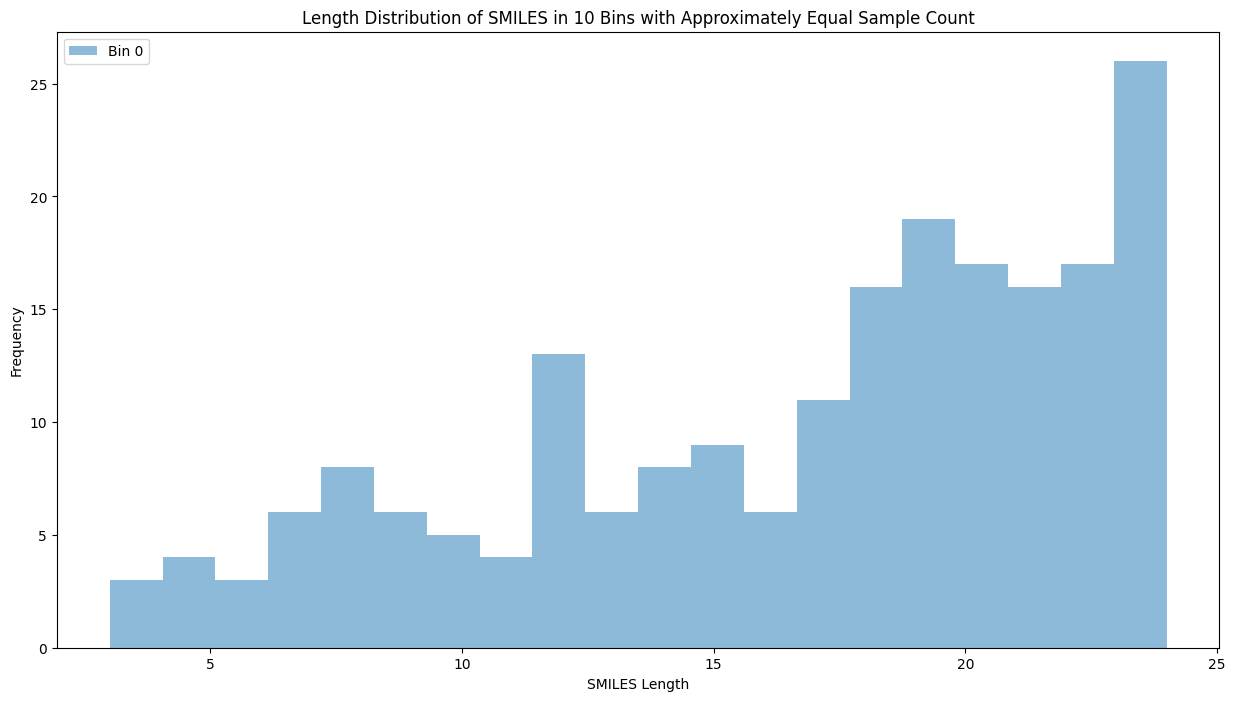

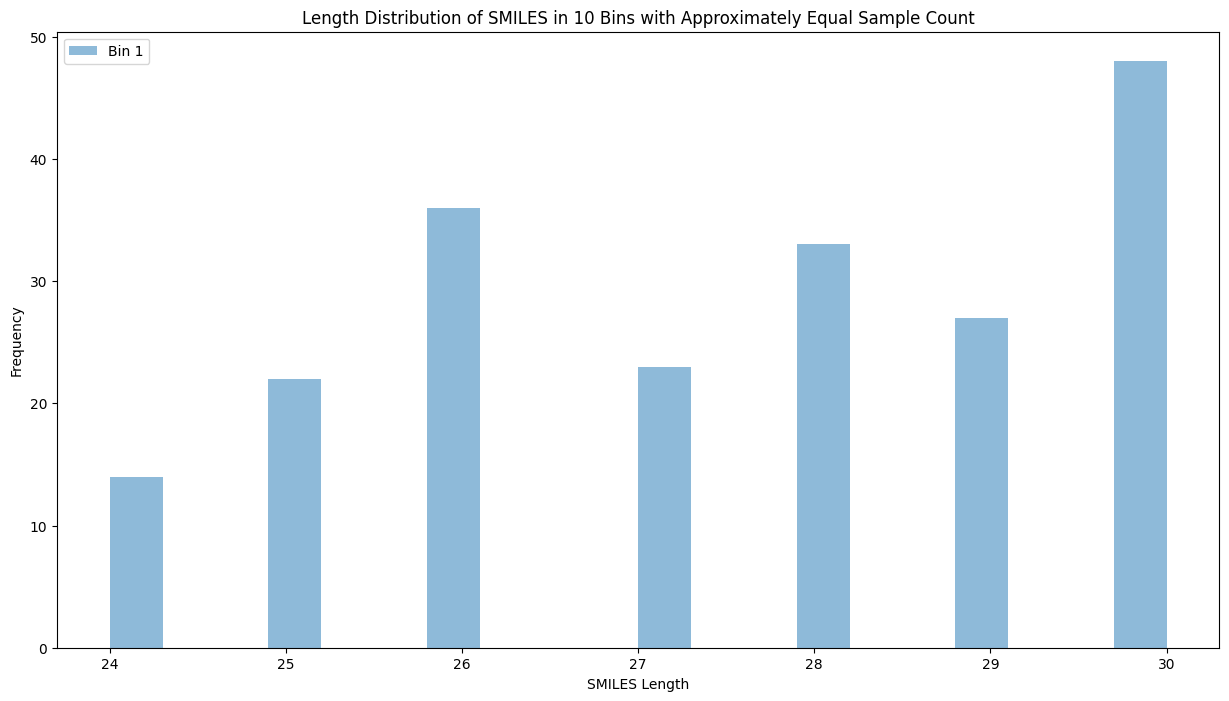

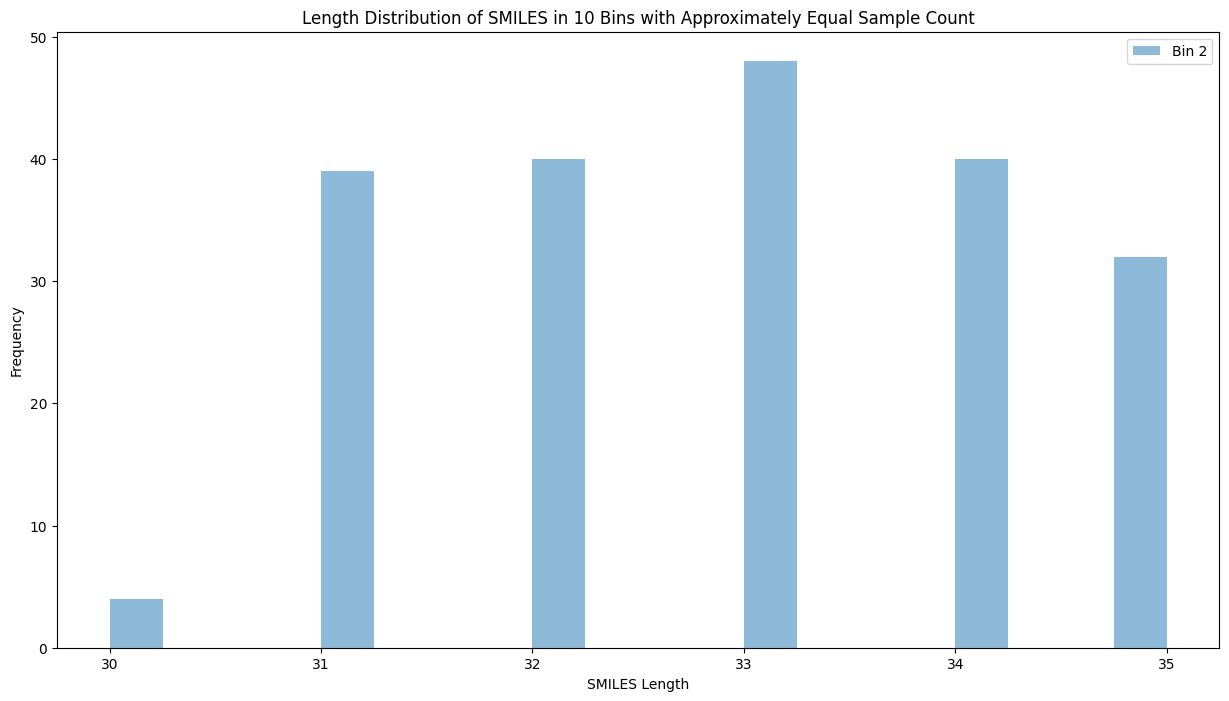

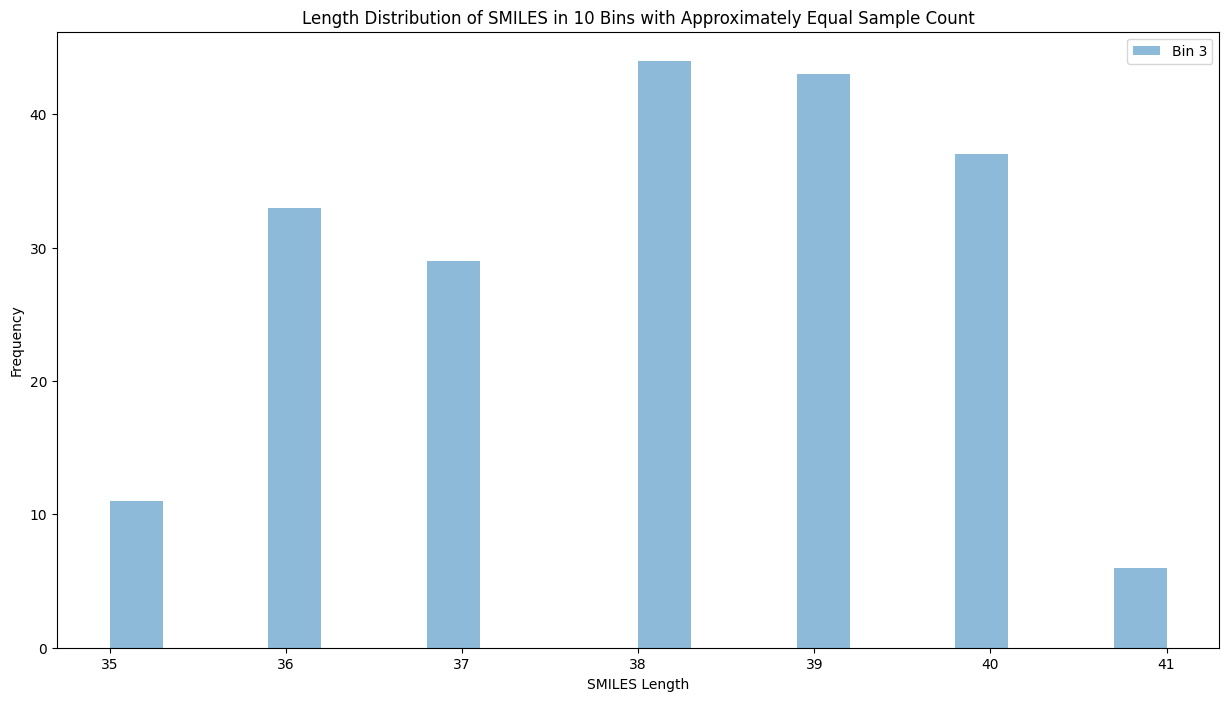

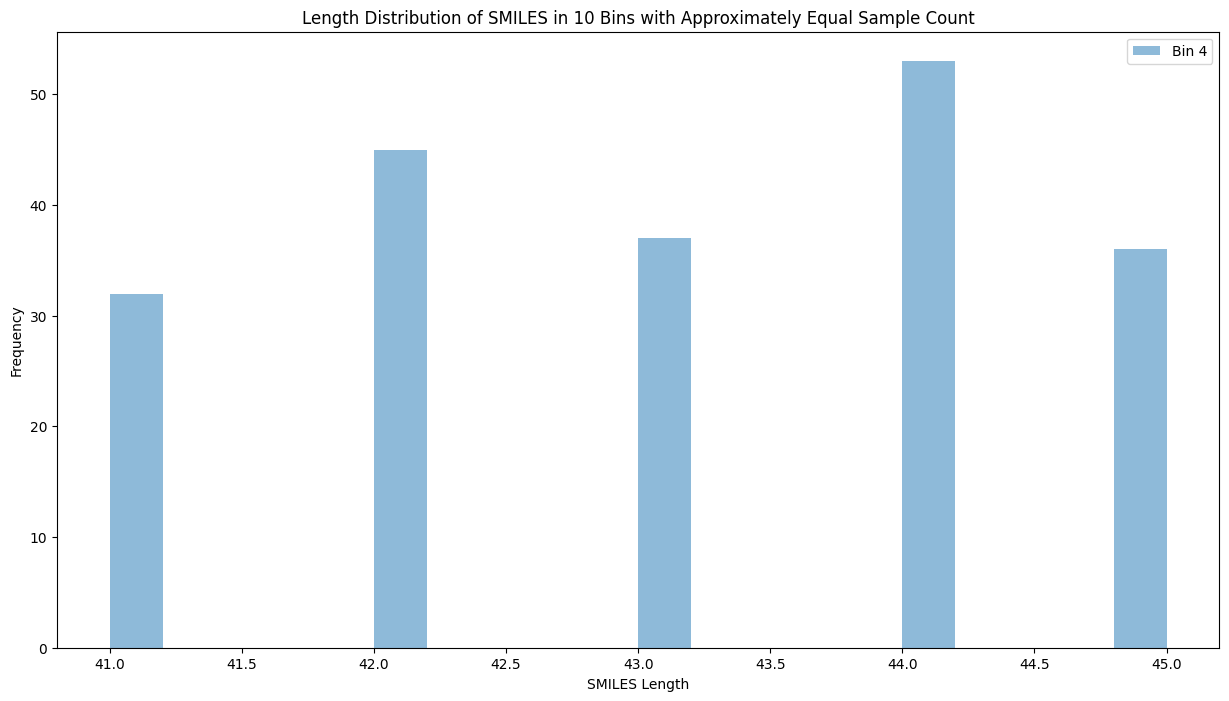

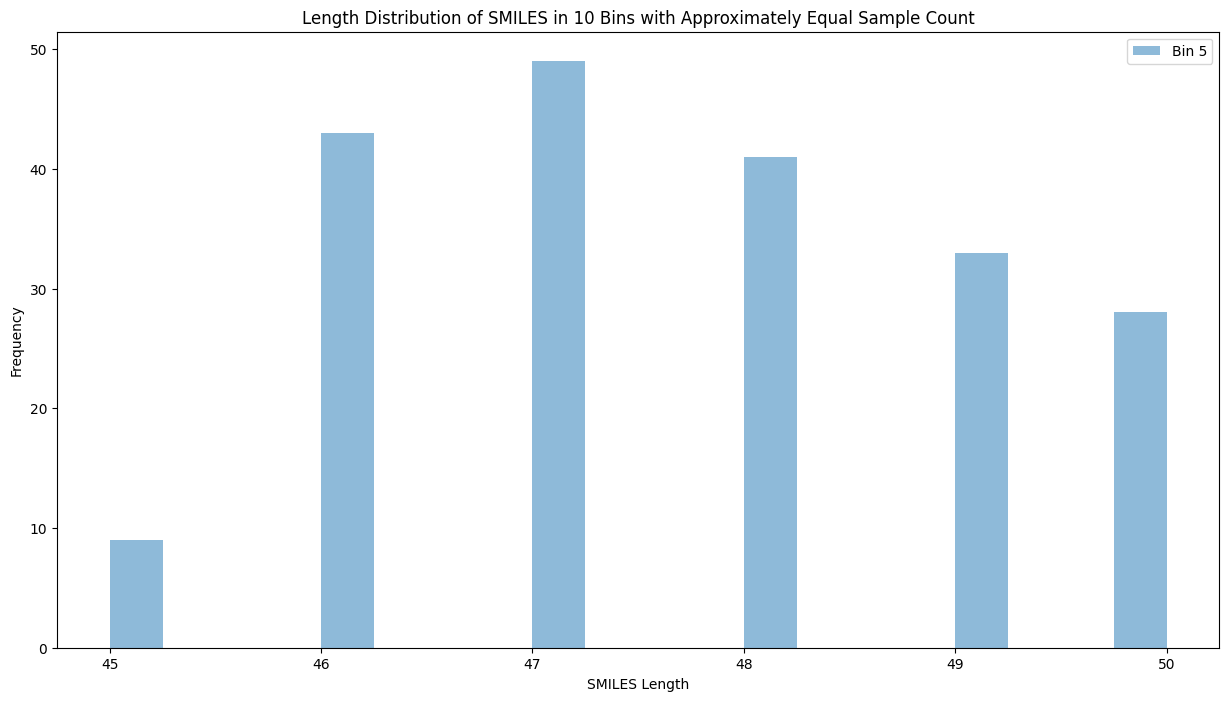

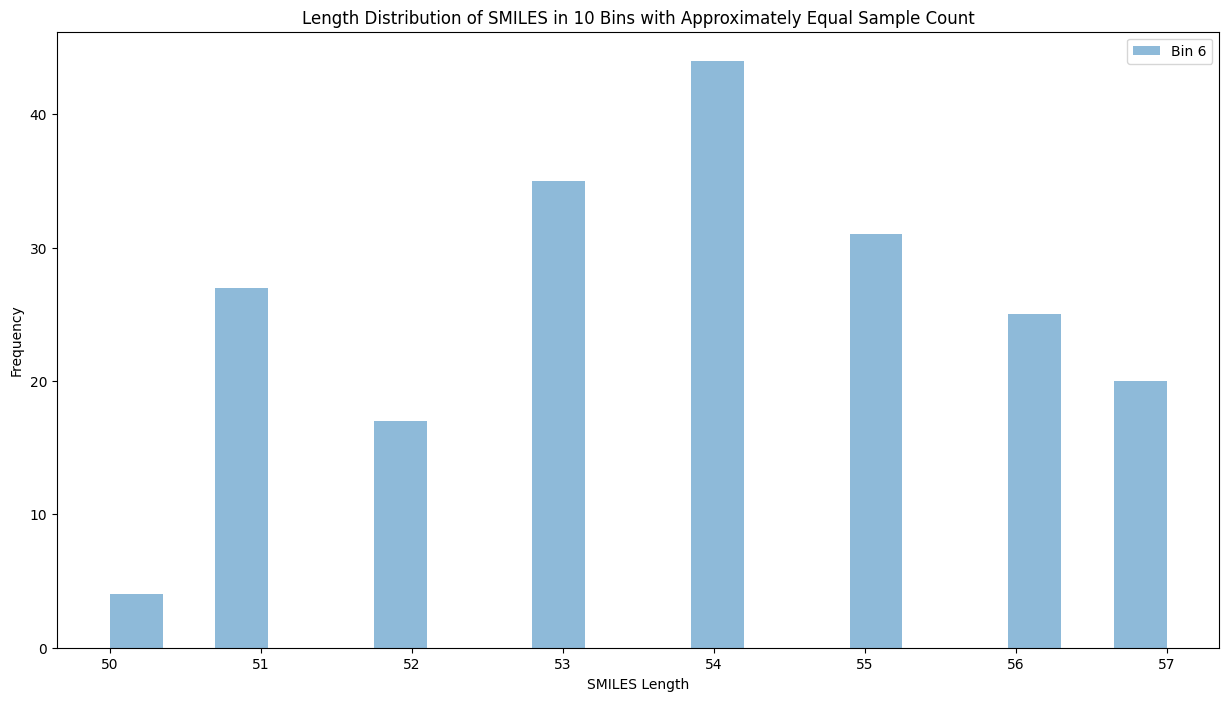

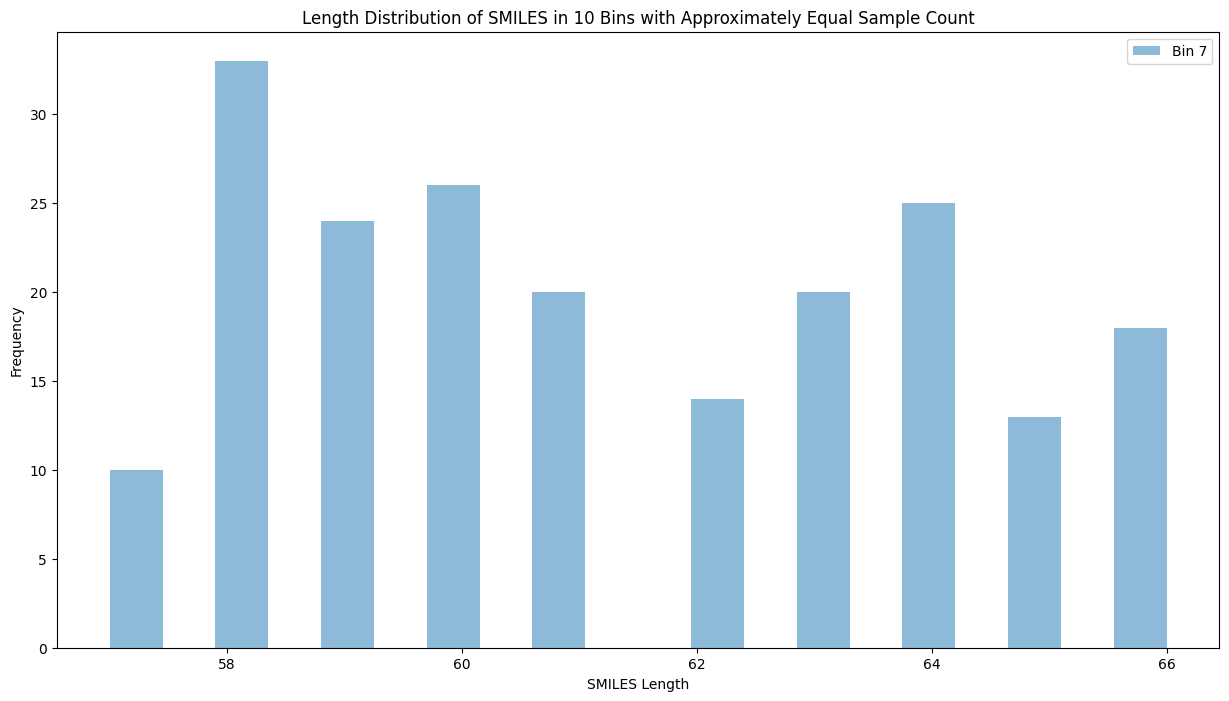

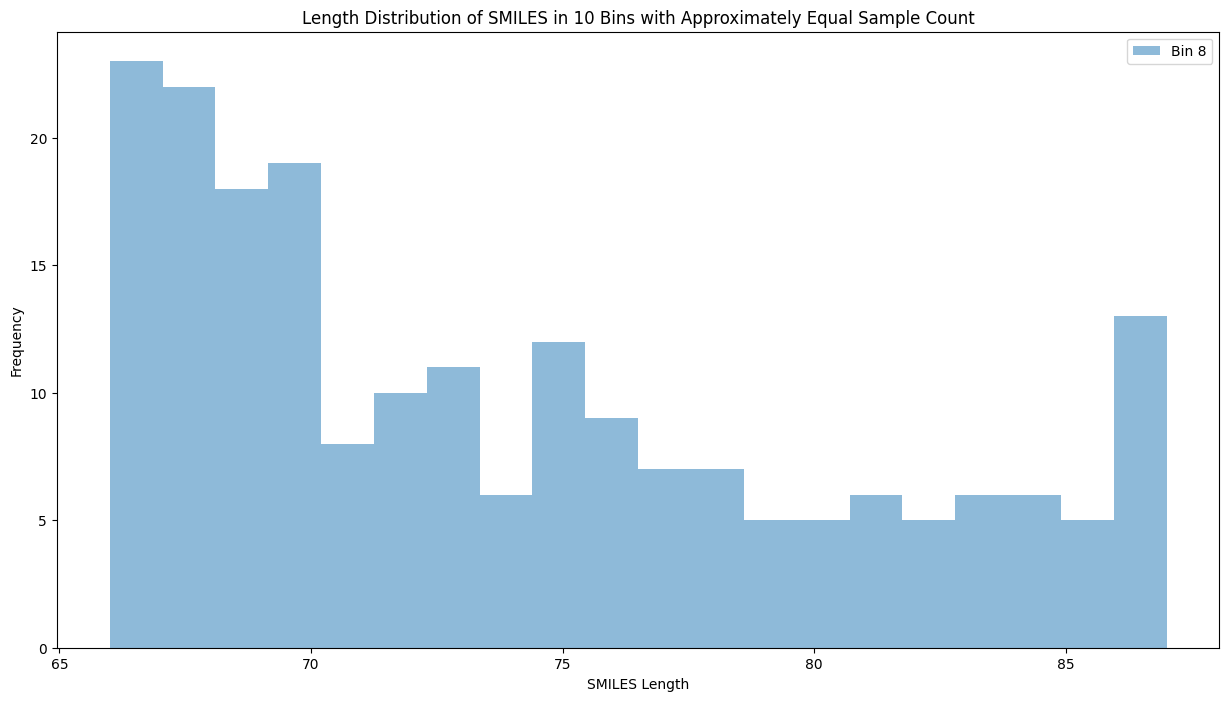

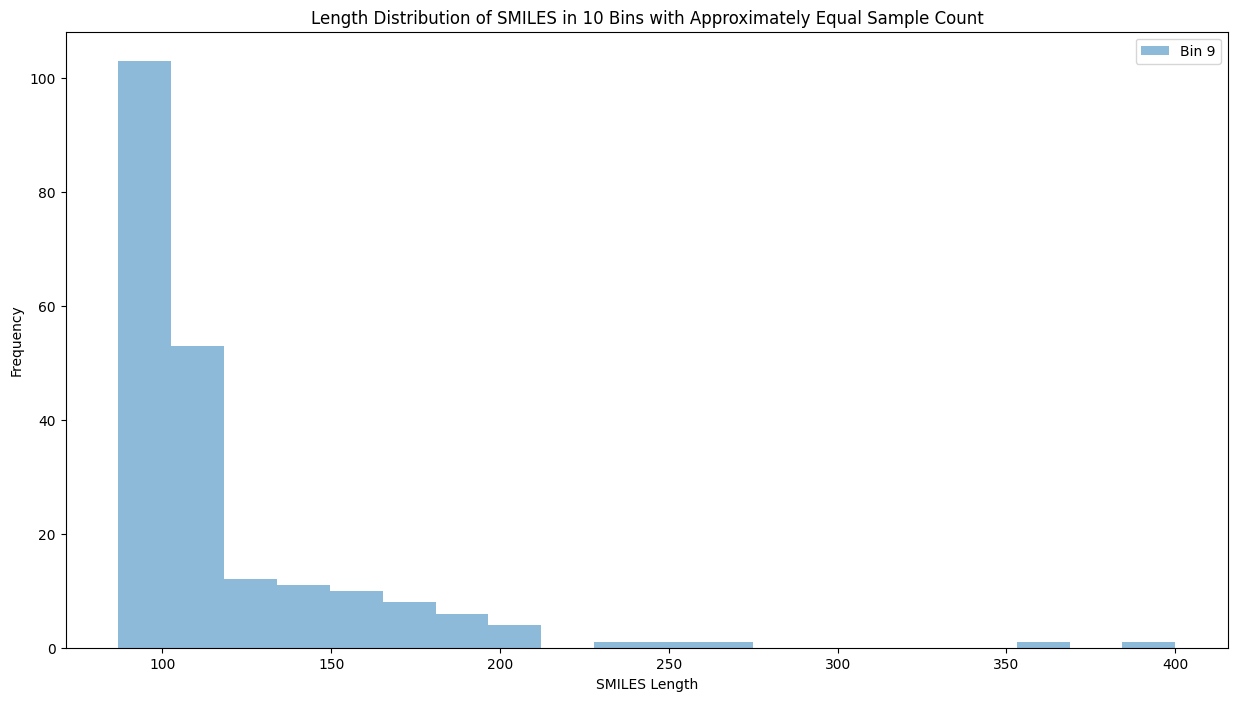

In [48]:

num_bins = 10

bin_size = len(valid_smiles_sorted) // num_bins
print('size of bin :',bin_size)

Dataset_Bin = []
for i in range(num_bins):
    start_idx = i * bin_size
    end_idx = start_idx + bin_size if i < num_bins - 1 else None
    bin_data = valid_smiles_sorted.iloc[start_idx:end_idx]
    Dataset_Bin.append(bin_data)

# Verify the size of each bin
for i, bin_data in enumerate(Dataset_Bin):
    print(f'Bin {i}: {len(bin_data)} samples')

# Plot length distribution in each bin
for bin_id, bin_data in enumerate(Dataset_Bin):
    plt.figure(figsize=(15, 8))
    bin_lengths = bin_data['smiles'].apply(len)
    plt.hist(bin_lengths, bins=20, alpha=0.5, label=f'Bin {bin_id}')
    plt.title('Length Distribution of SMILES in 10 Bins with Approximately Equal Sample Count')
    plt.xlabel('SMILES Length')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()



In [61]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def tokenize_and_convert_to_indices(tokenized_data, vocabulary):
    token_to_index = {token: idx + 1 for idx, token in enumerate(vocabulary)}
    token_to_index['UNK'] = 0  # Assign index 0 to UNK
    sequences = []
    for seq in tokenized_data:
        indices = [token_to_index.get(token, 0) for token in seq]
        sequences.append(np.array(indices))
    return sequences

def evaluate_lstm_model(model, X_bin_tokenized, Y_bin):
    # Tokenize and convert to indices
    X_bin_indices = tokenize_and_convert_to_indices(X_bin_tokenized, vocabulary)

    # Pad sequences
    X_bin_padded = pad_sequences(X_bin_indices, maxlen=max_length, padding='pre', truncating='pre')

    # Make predictions
    predictions = model.predict(X_bin_padded)

    # Convert predictions to class labels
    predicted_labels = [1 if pred > 0.5 else 0 for pred in predictions]

    # Evaluate performance metrics
    accuracy = accuracy_score(Y_bin, predicted_labels)
    precision = precision_score(Y_bin, predicted_labels)
    recall = recall_score(Y_bin, predicted_labels)
    f1 = f1_score(Y_bin, predicted_labels)

    return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1}

def evaluate_bilstm_model(model, X_bin_tokenized, Y_bin):
    # Tokenize and convert to indices
    X_bin_indices = tokenize_and_convert_to_indices(X_bin_tokenized, vocabulary)

    # Pad sequences
    X_bin_padded = pad_sequences(X_bin_indices, maxlen=max_length, padding='pre', truncating='pre')

    # Make predictions
    predictions = model.predict(X_bin_padded)

    # Convert predictions to class labels
    predicted_labels = [1 if pred > 0.5 else 0 for pred in predictions]

    # Evaluate performance metrics
    accuracy = accuracy_score(Y_bin, predicted_labels)
    precision = precision_score(Y_bin, predicted_labels)
    recall = recall_score(Y_bin, predicted_labels)
    f1 = f1_score(Y_bin, predicted_labels)

    return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1}


In [62]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.sequence import pad_sequences

# Assuming you have defined and trained your baseline, lstm, and bilstm models

# Define the number of bins
num_bins = 10
lstm_results = []
bilstm_results = []

# Iterate through each bin
for i in range(num_bins):
    # Extract the data for the current bin
    bin_data = Dataset_Bin[i]
    # Split the data into features (X_bin) and labels (Y_bin)
    X_bin = bin_data['smiles']
    Y_bin = bin_data['label']
    X_bin_tokenized = bin_data['tokens']
    print(X_bin)
    print(X_bin_tokenized)
    
    # Assuming you have defined and trained your baseline, lstm, and bilstm models
    # Replace the following lines with your actual model evaluation code
    lstm_result = evaluate_lstm_model(LSTMmodel, X_bin_tokenized, Y_bin)
    bilstm_result = evaluate_bilstm_model(model_bilstm_depth3, X_bin_tokenized, Y_bin)


    lstm_results.append(lstm_result)
    bilstm_results.append(bilstm_result)

# Print the results
print("Baseline Model Results:", baseline_results)
print("LSTM Model Results:", lstm_results)
print("BiLSTM Model Results:", bilstm_results)
# Cross validation and model serving

1204                         C=C
454                          CCO
509                         CCCO
434                        CCOCC
431                        C1CC1
                  ...           
470     CN1N(C(=O)C=C1C)c2ccccc2
1411    C1=CC=NC=C1C(N2CCOCC2)=O
585     COC(=O)c1ccc(cc1)C(=O)OC
1208    C(C(N1C(CCC1)=O)C(N)=O)C
1946    C1=C(NC(CC)=O)C=CC(=C1)O
Name: smiles, Length: 203, dtype: object
1204                                            [C, =, C]
454                                             [C, C, O]
509                                          [C, C, C, O]
434                                       [C, C, O, C, C]
431                                       [C, 1, C, C, 1]
                              ...                        
470     [C, N, 1, N, (, C, (, =, O, ), C, =, C, 1, C, ...
1411    [C, 1, =, C, C, =, N, C, =, C, 1, C, (, N, 2, ...
585     [C, O, C, (, =, O, ), c, 1, c, c, c, (, c, c, ...
1208    [C, (, C, (, N, 1, C, (, C, C, C, 1, ), =, O, ...
1946    [C, 1, =

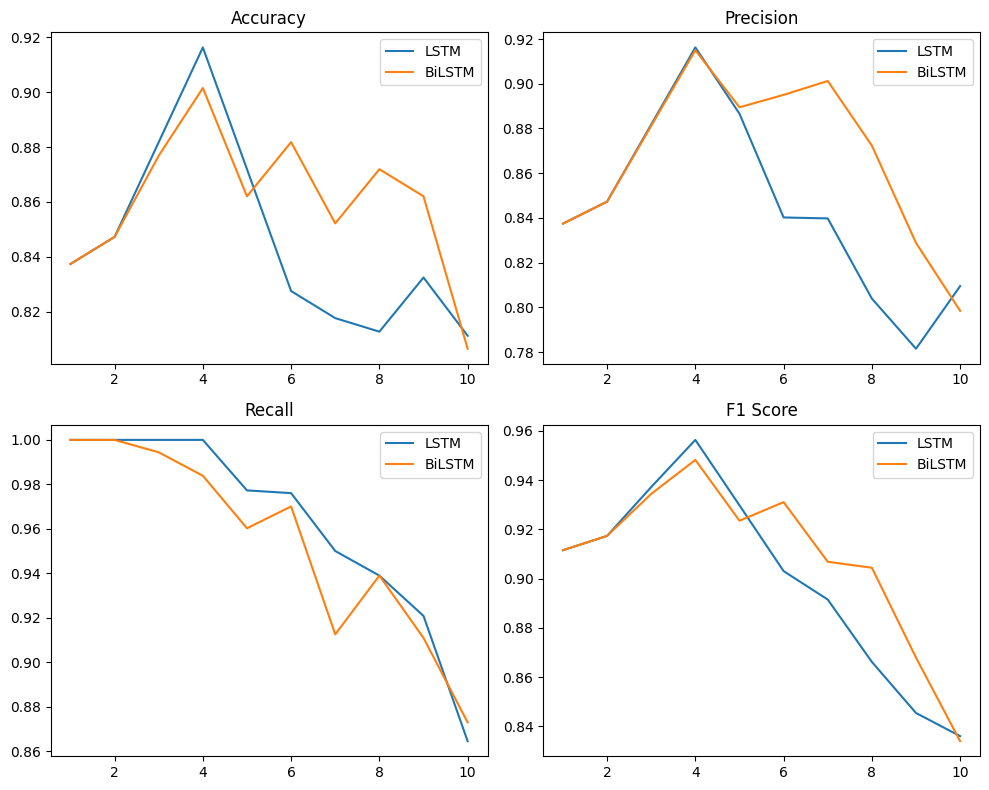

In [63]:
import matplotlib.pyplot as plt

# Extract metrics for LSTM and BiLSTM
lstm_accuracy = [result['accuracy'] for result in lstm_results]
lstm_precision = [result['precision'] for result in lstm_results]
lstm_recall = [result['recall'] for result in lstm_results]
lstm_f1 = [result['f1'] for result in lstm_results]

bilstm_accuracy = [result['accuracy'] for result in bilstm_results]
bilstm_precision = [result['precision'] for result in bilstm_results]
bilstm_recall = [result['recall'] for result in bilstm_results]
bilstm_f1 = [result['f1'] for result in bilstm_results]

# Create subplots for each metric
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Plot accuracy
axs[0, 0].plot(range(1, num_bins + 1), lstm_accuracy, label='LSTM')
axs[0, 0].plot(range(1, num_bins + 1), bilstm_accuracy, label='BiLSTM')
axs[0, 0].set_title('Accuracy')
axs[0, 0].legend()

# Plot precision
axs[0, 1].plot(range(1, num_bins + 1), lstm_precision, label='LSTM')
axs[0, 1].plot(range(1, num_bins + 1), bilstm_precision, label='BiLSTM')
axs[0, 1].set_title('Precision')
axs[0, 1].legend()

# Plot recall
axs[1, 0].plot(range(1, num_bins + 1), lstm_recall, label='LSTM')
axs[1, 0].plot(range(1, num_bins + 1), bilstm_recall, label='BiLSTM')
axs[1, 0].set_title('Recall')
axs[1, 0].legend()

# Plot F1 score
axs[1, 1].plot(range(1, num_bins + 1), lstm_f1, label='LSTM')
axs[1, 1].plot(range(1, num_bins + 1), bilstm_f1, label='BiLSTM')
axs[1, 1].set_title('F1 Score')
axs[1, 1].legend()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


## The plots show decreasing performance with increasing sequence lenghth, for both of the models, but overally BiLSTM has a better performance for longer sequences 

## In recall, LSRTM model performs signifiacantly better

## In Precision, BiLSTM does a better job

## in F1 score, BiLSTM overally performs better